In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%%writefile download.sh
#!/bin/bash

# Download and unzip weights if they are not already there  (~3GB)
if [ ! -d "./weights/PReMVOS_weights" ]; then
  echo "################# DOWNLOADING WEIGHTS #################"
  wget -P ./weights https://www.vision.rwth-aachen.de/media/resource_files/PReMVOS_weights.zip
  echo "################# UNZIPPING WEIGHTS #################"
  unzip ./weights/PReMVOS_weights.zip -d ./weights
fi

Writing download.sh


In [4]:
!bash download.sh

################# DOWNLOADING WEIGHTS #################
--2020-02-09 18:09:55--  https://www.vision.rwth-aachen.de/media/resource_files/PReMVOS_weights.zip
Resolving www.vision.rwth-aachen.de (www.vision.rwth-aachen.de)... 137.226.35.171
Connecting to www.vision.rwth-aachen.de (www.vision.rwth-aachen.de)|137.226.35.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3362386868 (3.1G) [application/zip]
Saving to: ‘./weights/PReMVOS_weights.zip’

PReMVOS_weights.zip 100%[===================>]   3.13G  28.5MB/s    in 1m 54s  

2020-02-09 18:11:50 (28.0 MB/s) - ‘./weights/PReMVOS_weights.zip’ saved [3362386868/3362386868]

################# UNZIPPING WEIGHTS #################
Archive:  ./weights/PReMVOS_weights.zip
   creating: ./weights/PReMVOS_weights/
   creating: ./weights/PReMVOS_weights/proposal_net/
   creating: ./weights/PReMVOS_weights/proposal_net/general_weights/
  inflating: ./weights/PReMVOS_weights/proposal_net/general_weights/proposal_general_weight

In [5]:
from keras import initializers
from __future__ import division, print_function, absolute_import
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, Conv2DTranspose
import numpy as np
from numpy import array
import sys
import cv2
import torch
import numpy as np
from math import ceil
from torch.autograd import Variable
import torch.nn as nn
import os
from torch.nn.modules.module import Module
from torch.autograd import Function
import math
import argparse
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


# scipy.ndimage imread

In [0]:
__all__ = ['imread']
def imread(fname, flatten=False, mode=None):

    try:
        from PIL import Image
    except ImportError:
        raise ImportError("Could not import the Python Imaging Library (PIL)"
                          " required to load image files.  Please refer to"
                          " http://pypi.python.org/pypi/PIL/ for installation"
                          " instructions.")

    im = Image.open(fname)
    if mode:
        im = im.convert(mode)
    if flatten:
        im = im.convert('F')
    result = array(im)
    return result

# read flo 

In [0]:
def read(file):
  TAG_FLOAT = 202021.25
  f = open(file,'rb')
  flo_number = np.fromfile(f, np.float32, count=1)[0]
  w = np.fromfile(f, np.int32, count=1)
  h = np.fromfile(f, np.int32, count=1)
  data = np.fromfile(f, np.float32, count=2*w[0]*h[0])
  # Reshape data into 3D array (columns, rows, bands)
  flow = np.resize(data, (int(h), int(w), 2))	
  f.close()

  return flow

# makeColorwheel

In [0]:
def makeColorwheel():
  RY = 15
  YG = 6
  GC = 4
  CB = 11
  BM = 13
  MR = 6
  ncols = RY + YG + GC + CB + BM + MR
  colorwheel = np.zeros([ncols, 3]) # r g b

  col = 0
  #RY
  colorwheel[0:RY, 0] = 255
  colorwheel[0:RY, 1] = np.floor(255*np.arange(0, RY, 1)/RY)
  col += RY

  #YG
  colorwheel[col:YG+col, 0]= 255 - np.floor(255*np.arange(0, YG, 1)/YG)
  colorwheel[col:YG+col, 1] = 255;
  col += YG;

  #GC
  colorwheel[col:GC+col, 1]= 255 
  colorwheel[col:GC+col, 2] = np.floor(255*np.arange(0, GC, 1)/GC)
  col += GC;

  #CB
  colorwheel[col:CB+col, 1]= 255 - np.floor(255*np.arange(0, CB, 1)/CB)
  colorwheel[col:CB+col, 2] = 255
  col += CB;

  #BM
  colorwheel[col:BM+col, 2]= 255 
  colorwheel[col:BM+col, 0] = np.floor(255*np.arange(0, BM, 1)/BM)
  col += BM;

  #MR
  colorwheel[col:MR+col, 2]= 255 - np.floor(255*np.arange(0, MR, 1)/MR)
  colorwheel[col:MR+col, 0] = 255
  return 	colorwheel


# computeColor

In [0]:
def computeColor(u, v):
  colorwheel = makeColorwheel();
  nan_u = np.isnan(u)
  nan_v = np.isnan(v)

  nan_u = np.where(nan_u)
  nan_v = np.where(nan_v) 

  u[nan_u] = 0
  u[nan_v] = 0
  v[nan_u] = 0 
  v[nan_v] = 0
  ncols = colorwheel.shape[0]
  radius = np.sqrt(u**2 + v**2)
  a = np.arctan2(-v, -u) / np.pi
  fk = (a+1) /2 * (ncols-1) # -1~1 maped to 1~ncols
  k0 = fk.astype(np.uint8)	 # 1, 2, ..., ncols
  k1 = k0+1
  k1[k1 == ncols] = 0
  f = fk - k0
  img = np.empty([k1.shape[0], k1.shape[1],3])
  ncolors = colorwheel.shape[1]
  for i in range(ncolors):
    tmp = colorwheel[:,i]
    col0 = tmp[k0]/255
    col1 = tmp[k1]/255
    col = (1-f)*col0 + f*col1
    idx = radius <= 1
    col[idx] = 1 - radius[idx]*(1-col[idx]) # increase saturation with radius    
    col[~idx] *= 0.75 # out of range
    img[:,:,2-i] = np.floor(255*col).astype(np.uint8)
  
  return img.astype(np.uint8)

# compute Img

In [0]:
def computeImg(flow):

  eps = sys.float_info.epsilon
  UNKNOWN_FLOW_THRESH = 1e9
  UNKNOWN_FLOW = 1e10

  u = flow[: , : , 0]
  v = flow[: , : , 1]
  maxu = -999
  maxv = -999

  minu = 999
  minv = 999

  maxrad = -1
  greater_u = np.where(u > UNKNOWN_FLOW_THRESH)
  greater_v = np.where(v > UNKNOWN_FLOW_THRESH)
  u[greater_u] = 0
  u[greater_v] = 0
  v[greater_u] = 0 
  v[greater_v] = 0
  maxu = max([maxu, np.amax(u)])
  minu = min([minu, np.amin(u)])

  maxv = max([maxv, np.amax(v)])
  minv = min([minv, np.amin(v)])
  rad = np.sqrt(np.multiply(u,u)+np.multiply(v,v))
  maxrad = max([maxrad, np.amax(rad)])
  u = u/(maxrad+eps)
  v = v/(maxrad+eps)
  img = computeColor(u, v)
  return img


# Show input image

In [0]:
im1_fn = '/gdrive/My Drive/DL_VOS/background_subtraction/Optical Flow/frame_0010.png';
im2_fn = '/gdrive/My Drive/DL_VOS/background_subtraction/Optical Flow/frame_0011.png';

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ceil', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


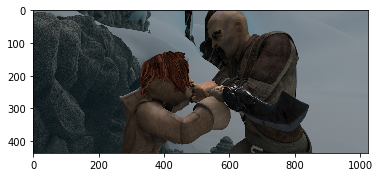

In [12]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(im1_fn)
imgplot = plt.imshow(img)
plt.show()

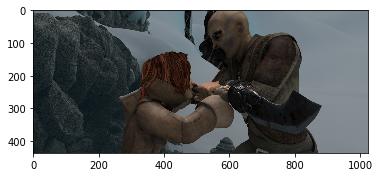

In [13]:
img=mpimg.imread(im2_fn)
imgplot = plt.imshow(img)
plt.show()

# Correlation 

In [0]:
ROUND_OFF = 50000
CUDA_NUM_THREADS = 1
WARPS_PER_BLOCK = 1
THREADS_PER_WARP = 1

In [0]:
def correlate_window(bottom0,bottom1,y1,x1,y2,x2,max_displacement):
    size = (2 * max_displacement + 1)*(2 * max_displacement + 1)
    val = 0
    window0 = np.zeros(shape = (bottom0.shape[1], max_displacement*2 + 1 ,max_displacement*2 + 1))
    window1 = np.zeros(shape = (bottom1.shape[1], max_displacement*2 + 1 ,max_displacement*2 + 1))
    #initialize window0
    #initialize window1
    for j in range(-max_displacement, max_displacement+1, 1):
        for i in range(-max_displacement, max_displacement+1,1):
            if ((j>-1 and j< bottom0.shape[2]) and (i>-1 and i<bottom0.shape[3])):
                try:
                    window0[:, j+max_displacement, i+max_displacement] = bottom0[0,:,y1+j,x1+i]
                except:
                    pass
                try:
                    window1[:, j+max_displacement,i+max_displacement] = bottom1[0,:,y2+j,x2+i]
                except:
                    pass
    window_mul = np.sum(np.multiply(window0 , window1))/(size* bottom0.shape[1])   
    return window_mul 

In [0]:
# == Correlation Kernel
def CorrelateData(nthreads,  num,  topwidth,  topheight,  topchannels,  topcount,
   max_displacement,  neighborhood_grid_radius,  neighborhood_grid_width,  kernel_radius,  kernel_size,  stride1,  stride2,
   bottomwidth,  bottomheight,  bottomchannels,
   bottom0, bottom1, top):
    #First (upper left) position of kernel upper-left corner in current center position of neighborhood in image 1
    sum = 0
    j = [0] * int(topchannels)
    top = [0] * int(topchannels)
    # Compute correlation
    x1 = stride1 + max_displacement
    y1 = stride1 + max_displacement
    x2 = stride2 + max_displacement
    y2 = stride2 + max_displacement
    tmp_result= np.zeros(shape = (1,int(topchannels),topheight,topwidth))
    for y1 in range (bottom0.shape[2]):
        for x1 in range (bottom0.shape[3]):
            ch = 0
            for j in range (- max_displacement, max_displacement + 1 , 1):
                for i in range (- max_displacement, max_displacement + 1 , 1):
                    y2 = y1 + j
                    x2 = x1 + i
                    sum1 = 0.0
                    if(x2<bottom1.shape[3] and y2<bottom1.shape[2]):
                        corr_wind = correlate_window(bottom0,bottom1,y1,x1,y2,x2,max_displacement)
                        sum1 = sum1 + corr_wind 
                        tmp_result[0][ch][y1][x1] = sum1 
                        ch = ch + 1          
    top = torch.cuda.FloatTensor(tmp_result)
    #top = tmp_result
    return top  

In [0]:
def CorrelateData_ongpu(rbot1, rbot2, output, batchSize, nOutputCols, nOutputRows, nOutputPlane, max_displacement, neighborhood_grid_radius_, 
                        neighborhood_grid_width_, kernel_radius_, kernel_size, stride1, stride2, paddedbottomwidth, paddedbottomheight,
                        nInputPlane, corr_type_multiply, stream):
    CUDA_NUM_THREADS = 1
    shared_memory_per_block = (kernel_size*kernel_size)*nInputPlane

    outputCount = nOutputCols * nOutputRows * nOutputPlane
    outputThreadCount = 1
    output = CorrelateData(
            outputThreadCount,
            batchSize, nOutputCols, nOutputRows, nOutputPlane, outputCount,
            max_displacement, neighborhood_grid_radius_,
            neighborhood_grid_width_, kernel_radius_, kernel_size,
            stride1, stride2,
            paddedbottomwidth, paddedbottomheight, nInputPlane,
            rbot1, rbot2, output
            )
    return output
   

In [0]:
def corr_cuda_forward(input1, input2, rbot1, rbot2, output, pad_size, kernel_size, max_displacement, stride1, stride2, corr_type_multiply):
    batchSize = input1.shape[0]

    nInputPlane = input1.shape[1]
    nInputRows = input1.shape[2]
    nInputCols = input1.shape[3]
    inputWidthHeight = nInputRows * nInputCols

    kernel_radius_ = (kernel_size - 1) / 2
    border_size_ = max_displacement + kernel_radius_
    paddedbottomheight = nInputRows + 2 * pad_size
    paddedbottomwidth = nInputCols + 2 * pad_size

    nOutputCols = math.ceil( 1.0 * (paddedbottomwidth - border_size_ * 2) / stride1)
    t = 1.0 * (paddedbottomwidth - border_size_ * 2) / stride1
    nOutputRows = math.ceil(1.0* (paddedbottomheight - border_size_ * 2) / stride1)
    neighborhood_grid_radius = max_displacement / stride2
    neighborhood_grid_width_ = neighborhood_grid_radius * 2 + 1

    nOutputPlane = neighborhood_grid_width_ * neighborhood_grid_width_
    input1_data =  input1
    input2_data = input2
    output_data =  output
    rbot1_data =  rbot1
    rbot2_data = rbot2

    pwidthheight = paddedbottomwidth * paddedbottomheight


    output = CorrelateData_ongpu(rbot1_data,rbot2_data,output_data,batchSize,nOutputCols,nOutputRows,nOutputPlane,max_displacement,neighborhood_grid_radius,neighborhood_grid_width_,kernel_radius_,kernel_size,stride1,stride2,paddedbottomwidth,paddedbottomheight,nInputPlane,corr_type_multiply,None)

    print('I am in the forward path')

    return output

# Correlation Function

In [0]:
class correlation(Function):

    def __init__(self, pad_size=3, kernel_size=3, max_displacement=20, stride1=1, stride2=1, corr_multiply=1):
        super(correlation, self).__init__()
        self.pad_size = pad_size
        self.kernel_size = kernel_size
        self.max_displacement = max_displacement
        self.stride1 = stride1
        self.stride2 = stride2
        self.corr_multiply = corr_multiply

    def forward(self, input1, input2):

        self.save_for_backward(input1, input2)
        
        rbot1 = input1
        rbot2 = input2
        output = input1

        output = corr_cuda_forward(input1, input2,
                               rbot1, rbot2,
                               output,
                               self.pad_size,
                               self.kernel_size,
                               self.max_displacement,
                               self.stride1,
                               self.stride2,
                               self.corr_multiply)

        return output





# Correlation Module

In [0]:
class Correlation(Module):

    def __init__(self, pad_size=None, kernel_size=None, max_displacement=None,
                 stride1=None, stride2=None, corr_multiply=None):
        super(Correlation, self).__init__()
        self.pad_size = pad_size
        self.kernel_size = kernel_size
        self.max_displacement = max_displacement
        self.stride1 = stride1
        self.stride2 = stride2
        self.corr_multiply = corr_multiply

    def reset_params(self):
        return

    def forward(self, input1, input2):
        return correlation(self.pad_size, self.kernel_size, self.max_displacement, self.stride1, self.stride2, self.corr_multiply)(input1, input2)
    def __repr__(self):
        return self.__class__.__name__

In [0]:
__all__ = [
    'pwc_dc_net'
    ]

def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):   
    return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                        padding=padding, dilation=dilation, bias=True),
            nn.LeakyReLU(0.1))

def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=True)

def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=True)



class PWCDCNet(nn.Module):
    """
    PWC-DC net. add dilation convolution and densenet connections

    """
    def __init__(self, md=4):
        """
        input: md --- maximum displacement (for correlation. default: 4), after warpping

        """
        super(PWCDCNet,self).__init__()

        self.conv1a  = conv(3,   16, kernel_size=3, stride=2)
        self.conv1aa = conv(16,  16, kernel_size=3, stride=1)
        self.conv1b  = conv(16,  16, kernel_size=3, stride=1)
        self.conv2a  = conv(16,  32, kernel_size=3, stride=2)
        self.conv2aa = conv(32,  32, kernel_size=3, stride=1)
        self.conv2b  = conv(32,  32, kernel_size=3, stride=1)
        self.conv3a  = conv(32,  64, kernel_size=3, stride=2)
        self.conv3aa = conv(64,  64, kernel_size=3, stride=1)
        self.conv3b  = conv(64,  64, kernel_size=3, stride=1)
        self.conv4a  = conv(64,  96, kernel_size=3, stride=2)
        self.conv4aa = conv(96,  96, kernel_size=3, stride=1)
        self.conv4b  = conv(96,  96, kernel_size=3, stride=1)
        self.conv5a  = conv(96, 128, kernel_size=3, stride=2)
        self.conv5aa = conv(128,128, kernel_size=3, stride=1)
        self.conv5b  = conv(128,128, kernel_size=3, stride=1)
        self.conv6aa = conv(128,196, kernel_size=3, stride=2)
        self.conv6a  = conv(196,196, kernel_size=3, stride=1)
        self.conv6b  = conv(196,196, kernel_size=3, stride=1)

        self.corr    = Correlation(pad_size=md, kernel_size=1, max_displacement=md, stride1=1, stride2=1, corr_multiply=1)
        self.leakyRELU = nn.LeakyReLU(0.1)
        
        nd = (2*md+1)**2
        dd = np.cumsum([128,128,96,64,32])
        dd = [int(d) for d in dd]

        od = nd
        self.conv6_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv6_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv6_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv6_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv6_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow6 = predict_flow(od+dd[4])
        self.deconv6 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat6 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1)
        
        od = nd+128+4
        self.conv5_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv5_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv5_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv5_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv5_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow5 = predict_flow(od+dd[4]) 
        self.deconv5 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat5 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+96+4
        self.conv4_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv4_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv4_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv4_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv4_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow4 = predict_flow(od+dd[4]) 
        self.deconv4 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat4 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+64+4
        self.conv3_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv3_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv3_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv3_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv3_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow3 = predict_flow(od+dd[4]) 
        self.deconv3 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat3 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+32+4
        self.conv2_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv2_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv2_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv2_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv2_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow2 = predict_flow(od+dd[4]) 
        self.deconv2 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        
        self.dc_conv1 = conv(od+dd[4], 128, kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv2 = conv(128,      128, kernel_size=3, stride=1, padding=2,  dilation=2)
        self.dc_conv3 = conv(128,      128, kernel_size=3, stride=1, padding=4,  dilation=4)
        self.dc_conv4 = conv(128,      96,  kernel_size=3, stride=1, padding=8,  dilation=8)
        self.dc_conv5 = conv(96,       64,  kernel_size=3, stride=1, padding=16, dilation=16)
        self.dc_conv6 = conv(64,       32,  kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv7 = predict_flow(32)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal(m.weight.data, mode='fan_in')
                if m.bias is not None:
                    m.bias.data.zero_()


    def warp(self, x, flo):
        """
        warp an image/tensor (im2) back to im1, according to the optical flow

        x: [B, C, H, W] (im2)
        flo: [B, 2, H, W] flow

        """
        B, C, H, W = x.size()
        # mesh grid 
        xx = torch.arange(0, W).view(1,-1).repeat(H,1)
        yy = torch.arange(0, H).view(-1,1).repeat(1,W)
        xx = xx.view(1,1,H,W).repeat(B,1,1,1)
        yy = yy.view(1,1,H,W).repeat(B,1,1,1)
        grid = torch.cat((xx,yy),1).float()

        if x.is_cuda:
            grid = grid.cuda()
        vgrid = Variable(grid) + flo

        # scale grid to [-1,1] 
        vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:]/max(W-1,1)-1.0
        vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:]/max(H-1,1)-1.0

        vgrid = vgrid.permute(0,2,3,1)        
        output = nn.functional.grid_sample(x, vgrid)
        mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
        mask = nn.functional.grid_sample(mask, vgrid)

        mask[mask<0.9999] = 0
        mask[mask>0] = 1
        
        return output*mask


    def forward(self,x):
        im1 = x[:,:3,:,:]
        im2 = x[:,3:,:,:]
        
        c11 = self.conv1b(self.conv1aa(self.conv1a(im1)))
        c21 = self.conv1b(self.conv1aa(self.conv1a(im2)))
        c12 = self.conv2b(self.conv2aa(self.conv2a(c11)))
        c22 = self.conv2b(self.conv2aa(self.conv2a(c21)))
        c13 = self.conv3b(self.conv3aa(self.conv3a(c12)))
        c23 = self.conv3b(self.conv3aa(self.conv3a(c22)))
        c14 = self.conv4b(self.conv4aa(self.conv4a(c13)))
        c24 = self.conv4b(self.conv4aa(self.conv4a(c23)))
        c15 = self.conv5b(self.conv5aa(self.conv5a(c14)))
        c25 = self.conv5b(self.conv5aa(self.conv5a(c24)))
        c16 = self.conv6b(self.conv6a(self.conv6aa(c15)))
        c26 = self.conv6b(self.conv6a(self.conv6aa(c25)))


        corr6 = self.corr(c16, c26) 
        corr6 = self.leakyRELU(corr6)   


        x = torch.cat((self.conv6_0(corr6), corr6),1)
        x = torch.cat((self.conv6_1(x), x),1)
        x = torch.cat((self.conv6_2(x), x),1)
        x = torch.cat((self.conv6_3(x), x),1)
        x = torch.cat((self.conv6_4(x), x),1)
        flow6 = self.predict_flow6(x)
        up_flow6 = self.deconv6(flow6)
        up_feat6 = self.upfeat6(x)

        
        warp5 = self.warp(c25, up_flow6*0.625)
        corr5 = self.corr(c15, warp5) 
        corr5 = self.leakyRELU(corr5)
        x = torch.cat((corr5, c15, up_flow6, up_feat6), 1)
        x = torch.cat((self.conv5_0(x), x),1)
        x = torch.cat((self.conv5_1(x), x),1)
        x = torch.cat((self.conv5_2(x), x),1)
        x = torch.cat((self.conv5_3(x), x),1)
        x = torch.cat((self.conv5_4(x), x),1)
        flow5 = self.predict_flow5(x)
        up_flow5 = self.deconv5(flow5)
        up_feat5 = self.upfeat5(x)

       
        warp4 = self.warp(c24, up_flow5*1.25)
        corr4 = self.corr(c14, warp4)  
        corr4 = self.leakyRELU(corr4)
        x = torch.cat((corr4, c14, up_flow5, up_feat5), 1)
        x = torch.cat((self.conv4_0(x), x),1)
        x = torch.cat((self.conv4_1(x), x),1)
        x = torch.cat((self.conv4_2(x), x),1)
        x = torch.cat((self.conv4_3(x), x),1)
        x = torch.cat((self.conv4_4(x), x),1)
        flow4 = self.predict_flow4(x)
        up_flow4 = self.deconv4(flow4)
        up_feat4 = self.upfeat4(x)


        warp3 = self.warp(c23, up_flow4*2.5)
        corr3 = self.corr(c13, warp3) 
        corr3 = self.leakyRELU(corr3)
        

        x = torch.cat((corr3, c13, up_flow4, up_feat4), 1)
        x = torch.cat((self.conv3_0(x), x),1)
        x = torch.cat((self.conv3_1(x), x),1)
        x = torch.cat((self.conv3_2(x), x),1)
        x = torch.cat((self.conv3_3(x), x),1)
        x = torch.cat((self.conv3_4(x), x),1)
        flow3 = self.predict_flow3(x)
        up_flow3 = self.deconv3(flow3)
        up_feat3 = self.upfeat3(x)


        warp2 = self.warp(c22, up_flow3*5.0) 
        corr2 = self.corr(c12, warp2)
        corr2 = self.leakyRELU(corr2)
        x = torch.cat((corr2, c12, up_flow3, up_feat3), 1)
        x = torch.cat((self.conv2_0(x), x),1)
        x = torch.cat((self.conv2_1(x), x),1)
        x = torch.cat((self.conv2_2(x), x),1)
        x = torch.cat((self.conv2_3(x), x),1)
        x = torch.cat((self.conv2_4(x), x),1)
        flow2 = self.predict_flow2(x)
 
        x = self.dc_conv4(self.dc_conv3(self.dc_conv2(self.dc_conv1(x))))
        flow2 += self.dc_conv7(self.dc_conv6(self.dc_conv5(x)))
        
        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

In [0]:
def pwc_dc_net(path=None):

    model = PWCDCNet()
    if path is not None:
        data = torch.load(path)
        if 'state_dict' in data.keys():
            model.load_state_dict(data['state_dict'])
        else:
            model.load_state_dict(data)
    return model

In [0]:
TAG_STRING = np.array(202021.25, dtype=np.float32)

def writeFlowFile(filename,uv):
	TAG_STRING = np.array(202021.25, dtype=np.float32)
	if uv.shape[2] != 2:
		sys.exit("writeFlowFile: flow must have two bands!");
	H = np.array(uv.shape[0], dtype=np.int32)
	W = np.array(uv.shape[1], dtype=np.int32)
	with open(filename, 'wb') as f:
		f.write(TAG_STRING.tobytes())
		f.write(W.tobytes())
		f.write(H.tobytes())
		f.write(uv.tobytes())


In [0]:

def write(flow, filename):

	assert type(filename) is str, "file is not str %r" % str(filename)
	assert filename[-4:] == '.flo', "file ending is not .flo %r" % file[-4:]

	height, width, nBands = flow.shape
	assert nBands == 2, "Number of bands = %r != 2" % nBands
	u = flow[: , : , 0]
	v = flow[: , : , 1]	
	assert u.shape == v.shape, "Invalid flow shape"
	height, width = u.shape

	f = open(filename,'wb')
	f.write(TAG_STRING)
	np.array(width).astype(np.int32).tofile(f)
	np.array(height).astype(np.int32).tofile(f)
	tmp = np.zeros((height, width*nBands))
	tmp[:,np.arange(width)*2] = u
	tmp[:,np.arange(width)*2 + 1] = v
	tmp.astype(np.float32).tofile(f)

	f.close()



In [25]:
cd /content

/content


In [0]:
flow_fn = '/gdrive/My Drive/DL_VOS/background_subtraction/frame_0010_final.flo';
pwc_model_fn = '/content/weights/PReMVOS_weights/optical_flow_net/pwc_net.pth.tar';

In [0]:
im_all = [imread(img) for img in [im1_fn, im2_fn]]
im_all = [im[:, :, :3] for im in im_all]

In [28]:
# rescale the image size to be multiples of 64
divisor = 64.
H = im_all[0].shape[0]
W = im_all[0].shape[1]

H_ = int(ceil(H/divisor) * divisor)
W_ = int(ceil(W/divisor) * divisor)
print('H,W,H_,W_>>',H,W,H_,W_)

H,W,H_,W_>> 436 1024 448 1024


In [0]:
for i in range(len(im_all)):
	im_all[i] = cv2.resize(im_all[i], (W_, H_))

for _i, _inputs in enumerate(im_all):
	im_all[_i] = im_all[_i][:, :, ::-1]
	im_all[_i] = 1.0 * im_all[_i]/255.0
	
	im_all[_i] = np.transpose(im_all[_i], (2, 0, 1))
	im_all[_i] = torch.from_numpy(im_all[_i])
	im_all[_i] = im_all[_i].expand(1, im_all[_i].size()[0], im_all[_i].size()[1], im_all[_i].size()[2])	
	im_all[_i] = im_all[_i].float()


In [30]:
im_all = torch.autograd.Variable(torch.cat(im_all,1).cuda(), volatile=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [31]:
net = pwc_dc_net(pwc_model_fn)
net = net.cuda()
net.eval()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


PWCDCNet(
  (conv1a): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)

In [32]:
flo = net(im_all)

I am in the forward path


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


I am in the forward path


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


I am in the forward path


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


I am in the forward path


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


I am in the forward path


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [0]:
flo = flo[0] * 20.0
flo = flo.cpu().data.numpy()

# scale the flow back to the input size 
flo = np.swapaxes(np.swapaxes(flo, 0, 1), 1, 2) # 
u_ = cv2.resize(flo[:,:,0],(W,H))
v_ = cv2.resize(flo[:,:,1],(W,H))
u_ *= W/ float(W_)
v_ *= H/ float(H_)
flo = np.dstack((u_,v_))

In [0]:
writeFlowFile(flow_fn, flo)


# compute color test

In [0]:
flow = read(flow_fn) 

In [0]:
img = computeImg(flow)	

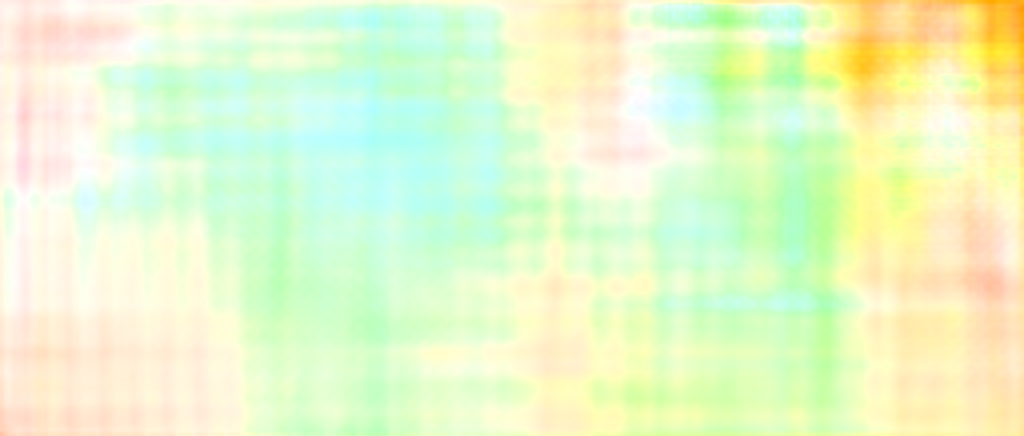

In [37]:
cv2_imshow(img)